***IMPORTS***

In [2]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 7.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.cuda
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

torch.manual_seed(1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
import re
import string
import emoji

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

In [6]:
nltk.download("punkt")
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


***LOADING THE DATASETS***

In [95]:
!gdown --id 1foE1JuZJeu5E_4qVge9kExzhvF32teuF
!gdown --id 13IWXrTjGTrfCd9l7dScZVO8ZvMicPU75

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1foE1JuZJeu5E_4qVge9kExzhvF32teuF
To: /content/tripadvisor_hotel_reviews_reduced.csv
100% 7.36M/7.36M [00:00<00:00, 133MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=13IWXrTjGTrfCd9l7dScZVO8ZvMicPU75
To: /content/scifi_reduced.txt
100% 43.1M/43.1M [00:00<00:00, 151MB/s]


In [96]:
# Loading the trip advisor hotel reviews dataset into a dataframe

df_trip = pd.read_csv("tripadvisor_hotel_reviews_reduced.csv")

In [7]:
# Loading the sci-fi dataset into a dataframe

with open(f'scifi.txt') as f:
    scifi_txt = f.read()

scifi_txt = scifi_txt.split('. ')

# Loading the sci-fi dataset into a dataframe
df_scifi = pd.DataFrame(scifi_txt, columns=['text'])

***EXPLORATORY DATA ANALYSIS (EDA)***

*Trip Advisor Hotel Reviews Data*

In [97]:
# Info about the dataframe

df_trip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  10000 non-null  object
 1   Rating  10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [98]:
# First few rows of the dataframe

df_trip.head()

,Review,Rating
0,fantastic service large hotel caters business ...,5
1,"great hotel modern hotel good location, locate...",4
2,3 star plus glasgowjust got 30th november 4 da...,4
3,nice stayed hotel nov 19-23. great little bout...,4
4,great place wonderful hotel ideally located me...,5


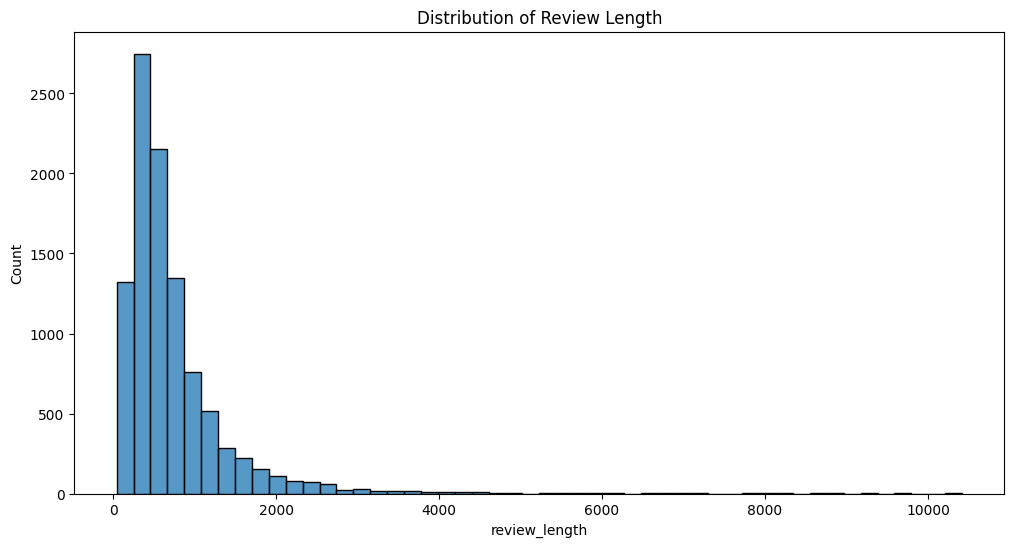

In [99]:
# Visualizing the distribution of length of the reviews

df_trip['review_length'] = df_trip['Review'].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(df_trip['review_length'], bins=50)
plt.title('Distribution of Review Length')
plt.show()

In [100]:
df_trip["review_length"].describe()

count    10000.000000
mean       730.082200
std        699.132521
min         44.000000
25%        340.750000
50%        540.000000
75%        859.000000
max      10420.000000
Name: review_length, dtype: float64

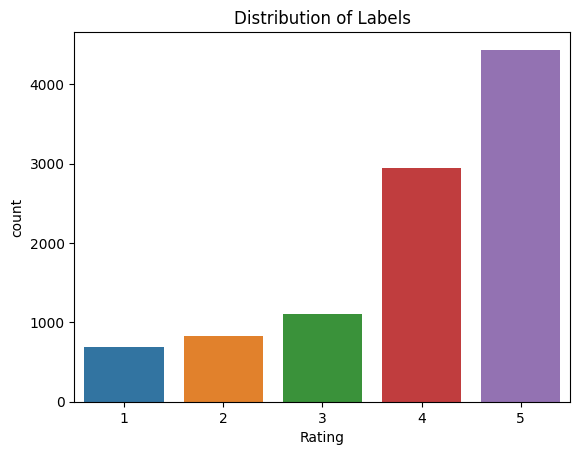

In [101]:
# Distribution of Labels

sns.countplot(x='Rating', data=df_trip)
plt.title('Distribution of Labels')
plt.show()

In [102]:
# Group by labels and describe review length statistics

print(df_trip.groupby('Rating')['review_length'].describe())

         count        mean         std   min     25%    50%     75%      max
Rating                                                                      
1        687.0  775.365357  718.289123  77.0  346.50  553.0  953.00   6511.0
2        828.0  853.996377  743.229338  74.0  411.75  643.5  998.50   7802.0
3       1108.0  792.102888  732.871652  55.0  374.75  590.5  929.50   9339.0
4       2941.0  745.359062  734.636714  61.0  335.00  544.0  883.00   9712.0
5       4436.0  674.320559  648.036990  44.0  324.00  503.5  788.25  10420.0


*Sci-Fi Data*

In [103]:
# Info about the dataset

df_scifi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 834557 entries, 0 to 834556
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   text               834557 non-null  object
 1   Preprocessed Text  834557 non-null  object
 2   text_length        834557 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 19.1+ MB


In [104]:
# First few rows of the dataframe

df_scifi.head()

,text,Preprocessed Text,text_length
0,MARCH # All Stories New and Complete Publisher...,march stori new complet publish editor publish...,134
1,"Volume #, No",volum,12
2,#,,1
3,"Copyright # by Quinn Publishing Company, Inc",copyright quinn publish compani inc,44
4,Application for Entry' as Second Class matter ...,applic entri second class matter post offic bu...,88


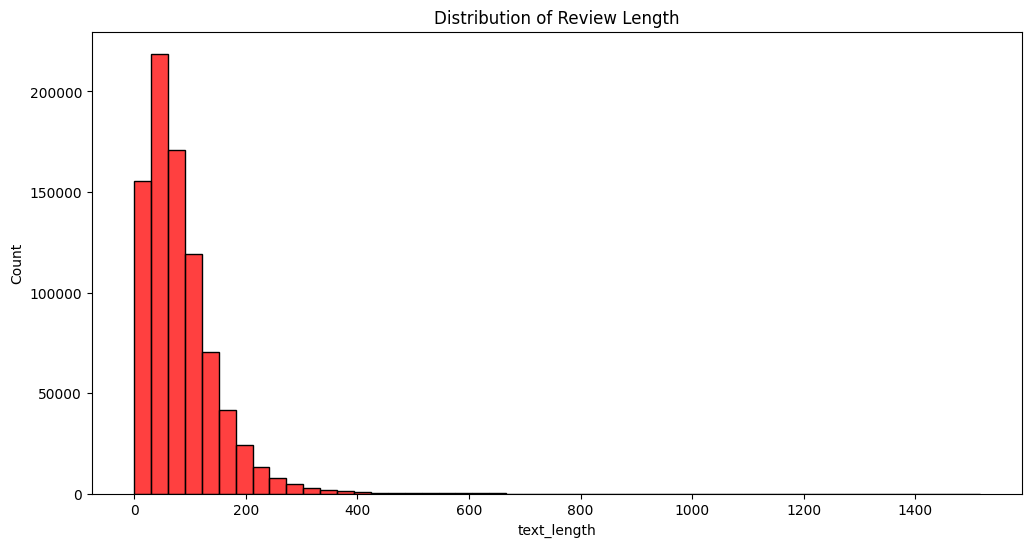

In [105]:
# Visualizing the distribution of length of the reviews

df_scifi['text_length'] = df_scifi['text'].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(df_scifi['text_length'], bins=50, color='red')
plt.title('Distribution of Review Length')
plt.show()

In [106]:
df_scifi["text_length"].describe()

count    834557.000000
mean         82.181900
std          63.603062
min           0.000000
25%          37.000000
50%          67.000000
75%         110.000000
max        1515.000000
Name: text_length, dtype: float64

***DATA PREPROCESSING***

In [107]:
def preprocess_review(review):
  # Convert all words to lower case
  review = review.lower()

  # Remove all punctuations
  review = review.translate(str.maketrans('', '', string.punctuation))

  # Remove all stop words
  # Tokenize the sentence
  tokens = nltk.word_tokenize(review)
  # Remove stop words
  clean_tokens = [token for token in tokens if not token.lower() in stop_words]
  # Join the tokens back into a sentence
  review = ' '.join(clean_tokens)

  # Removing HTML Tags, URLs and Website Links
  # Removing Website Links
  temp_text = review.split()

  for i in temp_text:
    if i[-4:] == ".com" or i[:4] == "www.":
      temp_text.remove(i)

  review = ' '.join(temp_text)

  # Remove HTML tags
  clean_text = re.sub('<[^<]+?>', '', review)

  # Remove URLs
  clean_text = re.sub(r'http\S+', '', clean_text)

  review = clean_text

  # Remove numbers
  review = re.sub(r'\d+', '', review)

  # Deemojize Emojis
  review = emoji.demojize(review)

  # Remove mentions
  review = re.sub(r'@\w+', '', review)

  # Stemming
  # Tokenize the sentence
  tokens = nltk.word_tokenize(review)

  # Stem the tokens
  stemmed_tokens = [stemmer.stem(token) for token in tokens]

  # Join the stemmed tokens back into a sentence
  review = ' '.join(stemmed_tokens)

  return review

***PREPROCESSING THE DATASETS***

*Trip Advisor Hotel Reviews Data*

In [108]:
df_trip["Preprocessed Reviews"] = df_trip["Review"].apply(preprocess_review)

In [109]:
cols = list(df_trip.columns.values)
cols

['Review', 'Rating', 'review_length', 'Preprocessed Reviews']

In [110]:
df_trip = df_trip[['Review', 'Preprocessed Reviews', 'Rating', 'review_length']]

In [111]:
df_trip.head()

,Review,Preprocessed Reviews,Rating,review_length
0,fantastic service large hotel caters business ...,fantast servic larg hotel cater busi corpor se...,5,371
1,"great hotel modern hotel good location, locate...",great hotel modern hotel good locat locat minu...,4,297
2,3 star plus glasgowjust got 30th november 4 da...,star plu glasgowjust got th novemb day visit g...,4,319
3,nice stayed hotel nov 19-23. great little bout...,nice stay hotel nov great littl boutiqu hotel ...,4,425
4,great place wonderful hotel ideally located me...,great place wonder hotel ideal locat metro sta...,5,285


Sci-fi Data


In [13]:
df_scifi["Preprocessed Text"] = df_scifi["text"].apply(preprocess_review)

In [14]:
cols = list(df_scifi.columns.values)
cols

['text', 'text_length', 'Preprocessed Text']

In [15]:
df_scifi = df_scifi[['text', 'Preprocessed Text', 'text_length']]

In [16]:
df_scifi.head()

,text,Preprocessed Text,text_length
0,MARCH # All Stories New and Complete Publisher...,march stori new complet publish editor publish...,134
1,"Volume #, No",volum,12
2,#,,1
3,"Copyright # by Quinn Publishing Company, Inc",copyright quinn publish compani inc,44
4,Application for Entry' as Second Class matter ...,applic entri second class matter post offic bu...,88


In [78]:
word_common=pd.Series(' '.join(df_scifi['Preprocessed Text']).lower().split()).value_counts()[:100]

In [75]:
# Select a random less common word slice
word_counts=pd.Series(' '.join(df_scifi['Preprocessed Text']).lower().split()).value_counts()
less_common = word_counts[1400:1500]

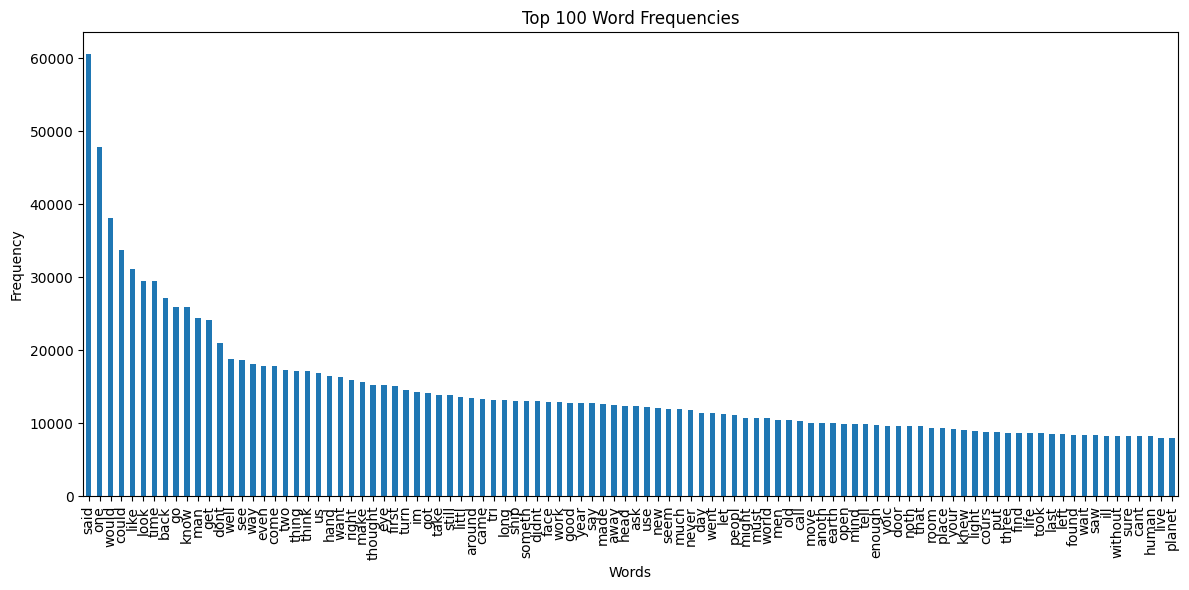

In [123]:
# Plotting the bar chart
plt.figure(figsize=(12, 6))
word_common.plot(kind='bar')
plt.title('Top 100 Word Frequencies')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

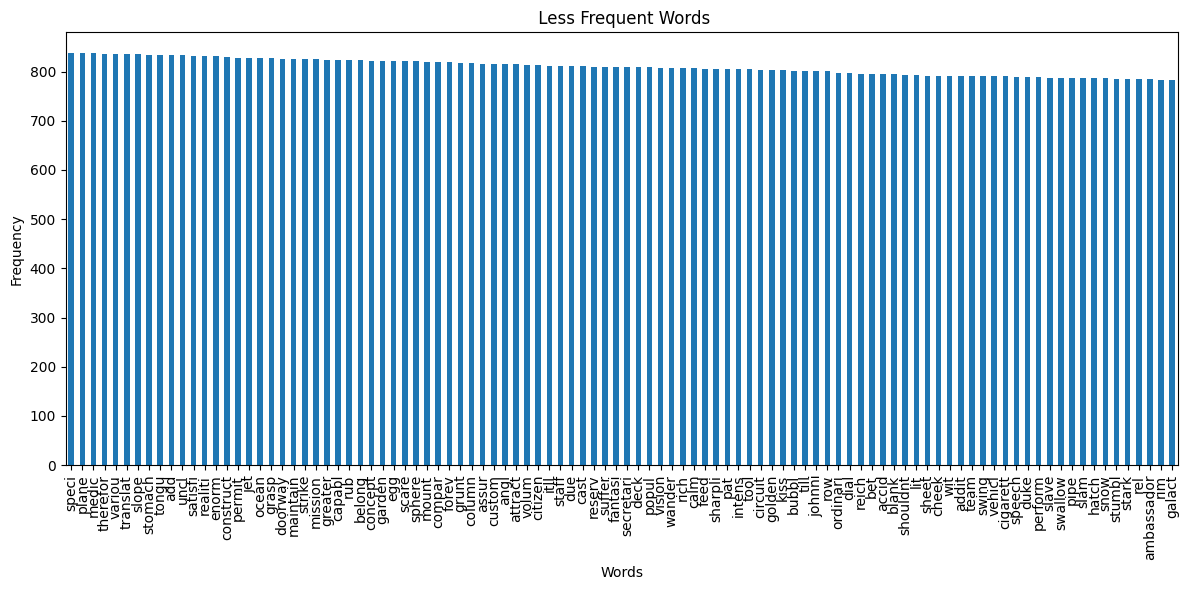

In [112]:
# Plotting the bar chart
plt.figure(figsize=(12, 6))
less_common.plot(kind='bar')
plt.title(' Less Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [113]:
# By deriving a set from `raw_text`, we deduplicate the array

raw_text = (' '.join(df_trip["Preprocessed Reviews"])).split()

In [114]:
# We create our vocab, context words and target words

vocab = set(raw_text)
vocab_size = len(vocab)

In [115]:
# Index the words

word_to_ix = {word: i for i, word in enumerate(vocab)}

In [ ]:
# # Define a function to make context and target words from the raw text

# def make_context_targets(CONTEXT_WIDTH, raw_text):
#     trip_data = []
#     for i in range(CONTEXT_WIDTH, len(raw_text) - CONTEXT_WIDTH):
#         context = [raw_text[i - 2], raw_text[i - 1], raw_text[i + 1], raw_text[i + 2]]
#         target = raw_text[i]
#         trip_data.append((context, target))
#     return trip_data

In [84]:
# Define a function to make vectors of the context words

def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)

In [83]:
class CBOWDataset(Dataset):

    def __init__(self, context_size, word_to_ix, raw_text=None, preprocessed_data=None):
        if preprocessed_data:
            self.data = preprocessed_data
        else:
            self.data = self._make_context_targets(context_size, raw_text)
        self.word_to_ix = word_to_ix

    def _make_context_targets(self, context_width, raw_text):
        data = []
        for i in range(context_width, len(raw_text) - context_width):
            # Using slicing to get the context words
            context = raw_text[i - context_width:i] + raw_text[i+1:i+1+context_width]
            target = raw_text[i]
            data.append((context, target))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        context_words, target_word = self.data[idx]

        # Check if words are in word_to_ix and Convert list of context words to their indices
        context_idxs = torch.tensor([self.word_to_ix.get(w, 0) for w in context_words], dtype=torch.long)
        target_idx = torch.tensor(self.word_to_ix.get(target_word, 0), dtype=torch.long)

        return context_idxs, target_idx

In [80]:
class CBOW(nn.Module):

    def __init__(self, vocab_size, EMBEDDING_DIM, CONTEXT_WIDTH, HIDDEN_DIM, word_to_ix):
        super(CBOW, self).__init__()

        self.word_to_ix = word_to_ix

        # Embedding layer to represent words in a dense form
        self.embeddings = nn.Embedding(vocab_size, EMBEDDING_DIM)

        # The input to this layer is CONTEXT_WIDTH words from the left, and CONTEXT_WIDTH from the right.
        # Each word is represented as an EMBEDDING_DIM sized vector.
        self.linear1 = nn.Linear(CONTEXT_WIDTH * 2 * EMBEDDING_DIM, HIDDEN_DIM)

        # An additional hidden layer for better representation
        self.linear2 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM)
        self.linear3 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM)
        self.linear4 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM)

        # The output layer predicts the central word, so it has vocab_size units
        self.linear5 = nn.Linear(HIDDEN_DIM, vocab_size)

    def forward(self, context_idxs):
        # Embed the words
        embeds = self.embeddings(context_idxs)

        # Flatten the embeddings
        embeds = embeds.view(-1, embeds.size(1) * embeds.size(2))

        # Pass through the layers
        out = F.relu(self.linear1(embeds))
        out = F.relu(self.linear2(out))
        out = F.relu(self.linear3(out))
        out = F.relu(self.linear4(out))
        out = self.linear5(out)

        # Predict the log probabilities of the center word
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

    def train_model(self, epochs, optimizer, train_dataloader, val_dataloader, device):
        loss_function = nn.NLLLoss()
        train_losses = []
        val_losses = []

        for epoch in range(epochs):
            self.train()
            total_loss = 0

            # Training loop with progress bar
            pbar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}")
            for context_idxs, target_idx in pbar:
                context_idxs, target_idx = context_idxs.to(device), target_idx.to(device)
                self.zero_grad()
                log_probs = self(context_idxs)
                loss = loss_function(log_probs, target_idx)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

                # Update the progress bar description
                pbar.set_description(f"Epoch {epoch+1}/{epochs} Loss: {loss.item():.4f}")


            train_losses.append(total_loss/len(train_dataloader))
            print(f"\nEpoch {epoch+1}, Training Loss: {total_loss/len(train_dataloader)}")

            self.eval()
            total_val_loss = 0

            # Validation loop with progress bar
            val_pbar = tqdm(val_dataloader, desc=f"Validating Epoch {epoch+1}/{epochs}")
            with torch.no_grad():
                for context_idxs, target_idx in val_pbar:
                    context_idxs, target_idx = context_idxs.to(device), target_idx.to(device)
                    log_probs = self(context_idxs)
                    loss = loss_function(log_probs, target_idx)
                    total_val_loss += loss.item()

                    # Update the validation progress bar description
                    val_pbar.set_description(f"Validating Epoch {epoch+1}/{epochs} Val Loss: {loss.item():.4f}")

            val_losses.append(total_val_loss/len(val_dataloader))
            print(f"Epoch {epoch+1}, Validation Loss: {total_val_loss/len(val_dataloader)}")
        return train_losses, val_losses

In [81]:
# Setting hyperparameters

EMBEDDING_DIM = 50
CONTEXT_WIDTH = 2
HIDDEN_DIM = 256
N_EPOCHS = 12

In [116]:
# Create the full dataset using the raw text
full_dataset = CBOWDataset(CONTEXT_WIDTH, word_to_ix, raw_text=raw_text)

# Split the dataset into training, validation, and test sets
train_data, temp_data = train_test_split(full_dataset.data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Using the split data to instantiate datasets
# raw_text is defaulted to None when using preprocessed_data
train_dataset = CBOWDataset(context_size=CONTEXT_WIDTH, word_to_ix=word_to_ix, preprocessed_data=train_data)
val_dataset = CBOWDataset(context_size=CONTEXT_WIDTH, word_to_ix=word_to_ix, preprocessed_data=val_data)
test_dataset = CBOWDataset(context_size=CONTEXT_WIDTH, word_to_ix=word_to_ix, preprocessed_data=test_data)

# Creating dataloaders for each dataset
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Initialize training

model = CBOW(vocab_size, EMBEDDING_DIM, CONTEXT_WIDTH, HIDDEN_DIM, word_to_ix)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.NLLLoss()

train_losses, val_losses = model.train_model(N_EPOCHS, optimizer, train_dataloader, val_dataloader, device)

Epoch 1/12:   0%|          | 0/12377 [00:00<?, ?it/s]


Epoch 1, Training Loss: 7.403620773769113


Validating Epoch 1/12:   0%|          | 0/1548 [00:00<?, ?it/s]

Epoch 1, Validation Loss: 7.285237136429286


Epoch 2/12:   0%|          | 0/12377 [00:00<?, ?it/s]


Epoch 2, Training Loss: 7.1132917226184365


Validating Epoch 2/12:   0%|          | 0/1548 [00:00<?, ?it/s]

Epoch 2, Validation Loss: 7.215800339553399


Epoch 3/12:   0%|          | 0/12377 [00:00<?, ?it/s]


Epoch 3, Training Loss: 6.94040741850739


Validating Epoch 3/12:   0%|          | 0/1548 [00:00<?, ?it/s]

Epoch 3, Validation Loss: 7.190593282073659


Epoch 4/12:   0%|          | 0/12377 [00:00<?, ?it/s]


Epoch 4, Training Loss: 6.840540145839504


Validating Epoch 4/12:   0%|          | 0/1548 [00:00<?, ?it/s]

Epoch 4, Validation Loss: 7.18962071631922


Epoch 5/12:   0%|          | 0/12377 [00:00<?, ?it/s]


Epoch 5, Training Loss: 6.777901918502638


Validating Epoch 5/12:   0%|          | 0/1548 [00:00<?, ?it/s]

Epoch 5, Validation Loss: 7.193694548089375


Epoch 6/12:   0%|          | 0/12377 [00:00<?, ?it/s]


Epoch 6, Training Loss: 6.7334103489515424


Validating Epoch 6/12:   0%|          | 0/1548 [00:00<?, ?it/s]

Epoch 6, Validation Loss: 7.197752870946584


Epoch 7/12:   0%|          | 0/12377 [00:00<?, ?it/s]


Epoch 7, Training Loss: 6.6976896935406165


Validating Epoch 7/12:   0%|          | 0/1548 [00:00<?, ?it/s]

Epoch 7, Validation Loss: 7.221754838637912


Epoch 8/12:   0%|          | 0/12377 [00:00<?, ?it/s]


Epoch 8, Training Loss: 6.6700691156648535


Validating Epoch 8/12:   0%|          | 0/1548 [00:00<?, ?it/s]

Epoch 8, Validation Loss: 7.195720233966521


Epoch 9/12:   0%|          | 0/12377 [00:00<?, ?it/s]


Epoch 9, Training Loss: 6.645063643136894


Validating Epoch 9/12:   0%|          | 0/1548 [00:00<?, ?it/s]

Epoch 9, Validation Loss: 7.222690714114088


Epoch 10/12:   0%|          | 0/12377 [00:00<?, ?it/s]


Epoch 10, Training Loss: 6.625030139059495


Validating Epoch 10/12:   0%|          | 0/1548 [00:00<?, ?it/s]

Epoch 10, Validation Loss: 7.21593386843531


Epoch 11/12:   0%|          | 0/12377 [00:00<?, ?it/s]


Epoch 11, Training Loss: 6.606897908901373


Validating Epoch 11/12:   0%|          | 0/1548 [00:00<?, ?it/s]

Epoch 11, Validation Loss: 7.228480350139529


Epoch 12/12:   0%|          | 0/12377 [00:00<?, ?it/s]


Epoch 12, Training Loss: 6.591087840067085


Validating Epoch 12/12:   0%|          | 0/1548 [00:00<?, ?it/s]

Epoch 12, Validation Loss: 7.229028183668467


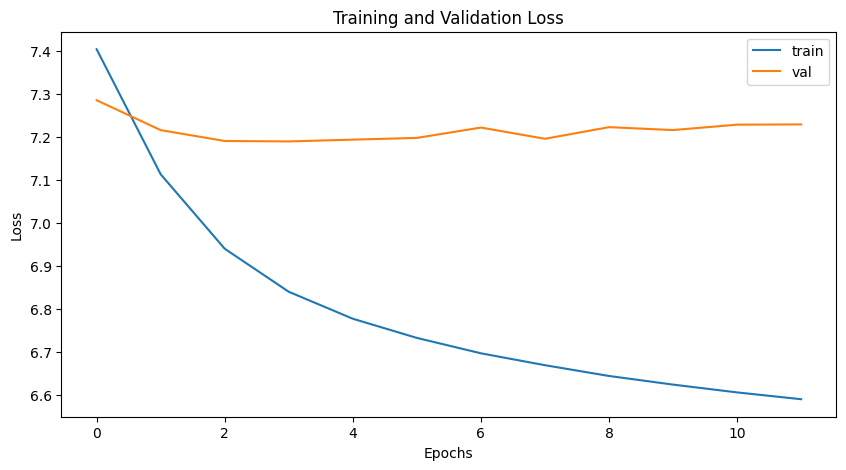

In [ ]:
# After training
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
def test_model(self, test_dataloader):
    self.eval()
    total_loss = 0
    loss_function = nn.NLLLoss()

    test_pbar = tqdm(test_dataloader, desc="Testing")
    with torch.no_grad():
        for context, target in test_pbar:
            context, target = context.to(device), target.to(device)
            log_probs = self(context)
            loss = loss_function(log_probs, target)
            total_loss += loss.item()

            test_pbar.set_description(f"Testing Loss: {loss.item():.4f}")

    avg_test_loss = total_loss / len(test_dataloader)
    print(f"Average Testing Loss: {avg_test_loss}")
    return avg_test_loss

# Run the test
test_model(model, test_dataloader)

Testing:   0%|          | 0/1548 [00:00<?, ?it/s]

Average Testing Loss: 7.258329613880286


7.258329613880286

In [ ]:
def test_model(self, test_dataloader):
    self.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    loss_function = nn.NLLLoss()

    test_pbar = tqdm(test_dataloader, desc="Testing")
    with torch.no_grad():
        for context, target in test_pbar:
            context, target = context.to(device), target.to(device)
            log_probs = self(context)
            loss = loss_function(log_probs, target)
            total_loss += loss.item()

            # Calculate the number of correct predictions
            _, predicted = torch.max(log_probs, 1)
            correct_predictions += (predicted == target).sum().item()
            total_samples += target.size(0)

            test_pbar.set_description(f"Testing Loss: {loss.item():.4f}")

    avg_test_loss = total_loss / len(test_dataloader)
    accuracy = correct_predictions / total_samples
    print(f"Average Testing Loss: {avg_test_loss}")
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    return avg_test_loss, accuracy

# Run the test
avg_test_loss, accuracy = test_model(model, test_dataloader)

Testing:   0%|          | 0/1548 [00:00<?, ?it/s]

Average Testing Loss: 7.258329613880286
Test Accuracy: 7.06%


Sci-fi CBOW2


In [117]:
# By deriving a set from `raw_text`, we deduplicate the array

raw_text_scifi = (' '.join(df_scifi["Preprocessed Text"])).split()

In [118]:
# We create our vocab, context words and target words

vocab_scifi = set(raw_text_scifi)
vocab_size_scifi = len(vocab_scifi)

In [124]:
# Index the words
word_to_ix_scifi = {word: i for i, word in enumerate(vocab_scifi)}
ix_to_word_scifi = {ix:word for ix, word in enumerate(vocab_scifi)}


In [120]:
# Setting hyperparameters

EMBEDDING_DIM_SCIFI = 50
CONTEXT_WIDTH_SCIFI = 2
HIDDEN_DIM_SCIFI = 256
N_EPOCHS_SCIFI = 3

In [121]:
# Create the full dataset using the raw text
full_dataset_scifi = CBOWDataset(CONTEXT_WIDTH_SCIFI, word_to_ix_scifi, raw_text=raw_text_scifi)


# Split the dataset into training, validation, and test sets
train_data_scifi, temp_data = train_test_split(full_dataset_scifi.data, test_size=0.2, random_state=42)
val_data_scifi, test_data_scifi = train_test_split(temp_data, test_size=0.5, random_state=42)


# Using the split data to instantiate datasets
# raw_text is defaulted to None when using preprocessed_data
train_dataset_scifi = CBOWDataset(context_size=CONTEXT_WIDTH_SCIFI, word_to_ix=word_to_ix_scifi, preprocessed_data=train_data_scifi)
val_dataset_scifi  = CBOWDataset(context_size=CONTEXT_WIDTH_SCIFI, word_to_ix=word_to_ix_scifi, preprocessed_data=val_data_scifi)
test_dataset_scifi  = CBOWDataset(context_size=CONTEXT_WIDTH_SCIFI, word_to_ix=word_to_ix_scifi, preprocessed_data=test_data_scifi)

# Creating dataloaders for each dataset
train_dataloader = DataLoader(train_dataset_scifi , batch_size=64, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset_scifi , batch_size=64, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset_scifi , batch_size=64, shuffle=False, num_workers=4)



In [122]:
# Initialize training

model_scifi = CBOW(vocab_size_scifi, EMBEDDING_DIM_SCIFI,CONTEXT_WIDTH_SCIFI, HIDDEN_DIM_SCIFI, word_to_ix_scifi)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_scifi.to(device)

optimizer = torch.optim.Adam(model_scifi.parameters(), lr=0.001)
loss_function = nn.NLLLoss()

train_losses, val_losses = model_scifi.train_model(N_EPOCHS_SCIFI, optimizer, train_dataloader, val_dataloader, device)

Epoch 1/3:   0%|          | 0/80523 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


KeyboardInterrupt: ignored

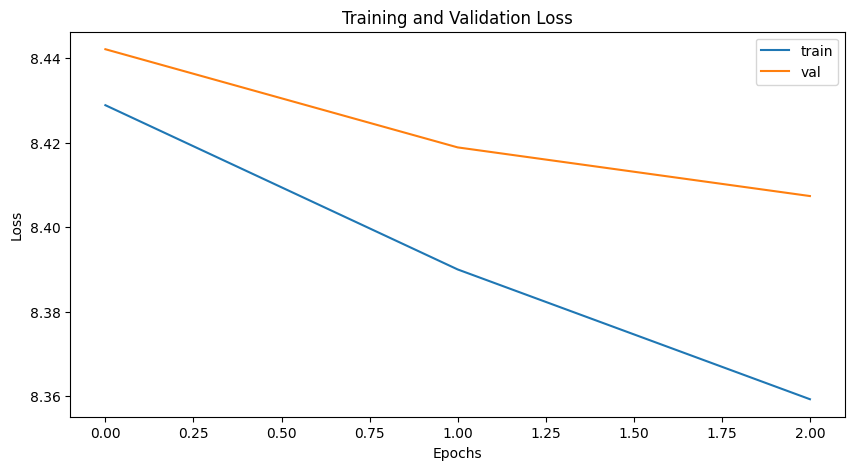

In [ ]:
# After training
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# slope, scare, rich are less frequent
words_scifi=["old","long", "rich","said","cant","scare","time","planet","slope"]

def get_closest_word(word, topn=5):
  word_distance = []
  emb = model_scifi.embeddings
  pdist = nn.PairwiseDistance()
  i = word_to_ix_scifi[word]
  lookup_tensor_i = torch.tensor([i], dtype=torch.long).to(device)
  v_i = emb(lookup_tensor_i)
  for j in range(len(vocab_scifi)):
    if j != i:
      lookup_tensor_j = torch.tensor([j], dtype=torch.long).to(device)
      v_j = emb(lookup_tensor_j)
      word_distance.append((ix_to_word_scifi[j], float(pdist(v_i, v_j))))
  word_distance.sort(key=lambda x: x[1])
  return word_distance[:topn]

for x in words_scifi:
  print(get_closest_word(x))


[('sexslav', 6.6741862297058105), ('mdear', 6.713298797607422), ('toreador', 6.836635589599609), ('herbi', 6.858548641204834), ('bodyfluid', 6.881492614746094)]
